In [1]:
import pickle
from pathlib import Path
import glob, os, re, sys
sys.path.append('../')

import configparser

import numpy as np
from scipy.stats import binned_statistic_2d

import astro_helper as ah
import PRFM_helper as ph

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib import rc
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
rc('axes', linewidth=1.5)
rc('axes', edgecolor='#3C3C3C')
plt.style.use('mpl_style_Jeffreson.mplstyle')

# Load the data

In [2]:
titles = ['MW']

In [3]:
def get_image_data(filename):
    with open(filename, "rb") as f:
        xpix = np.fromfile(f, dtype=np.int32, count=1)[0]
        ypix = np.fromfile(f, dtype=np.int32, count=1)[0]
        img = np.fromfile(f, dtype=np.float32, count=xpix*ypix)
    img = np.reshape(img, (xpix, ypix))
    return img

## PRFM, unresolved

In [4]:
# SH03 files
dirs_PRFM = [
    '/LtU/LOW-PRFM/'
]
tau_deps_PRFM, tau_dyns_PRFM, SFRs_PRFM = [], [], []
for dir_PRFM in dirs_PRFM:
    filenames_Sfr = sorted(glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_PRFM+'/output/Sfr_proj_*'),
                           key=lambda x: int(x.split('_')[-1])) # Msol/kpc^2/yr
    filenames_Veldisp = sorted(glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_PRFM+'/output/Veldisp_proj_*'),
                                key=lambda x: int(x.split('_')[-1]))
    filenames_PDE = sorted(glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_PRFM+'/output/PDE_proj_*'),
                            key=lambda x: int(x.split('_')[-1]))
    filenames_Sigmagas = sorted(glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_PRFM+'/output/density_proj_*'),
                                key=lambda x: int(x.split('_')[-1])) # 10^9 Msol/kpc^2

    # load all as a flat raveled array
    testfile = get_image_data(filenames_Sfr[0])
    Sfrs = np.array([np.ravel(get_image_data(file)) for file in filenames_Sfr]).flatten()
    Veldisps = np.array([np.ravel(get_image_data(file)) for file in filenames_Veldisp]).flatten()
    PDEs = np.array([np.ravel(get_image_data(file)) for file in filenames_PDE]).flatten()
    Sigmagas = np.array([np.ravel(get_image_data(file)) for file in filenames_Sigmagas]).flatten()

    # depletion time, something to do with how projected values are calculated?
    tau_deps = Sigmagas * 0.08**2 / Sfrs
    tau_deps_PRFM.append(tau_deps)
    SFRs_PRFM.append(Sfrs)

    # dynamical time, probably out by some kB factor in internal units
    press_unit = 1.e9*1.99e33*(1.e5)**2/(3.086e21)**3
    Sigma_unit = 1.e9*1.99e33/(3.086e21)**2
    Veldisp_unit = 1.e5
    tau_dyns = (Sigmagas*Sigma_unit * Veldisps*Veldisp_unit / (PDEs*press_unit)) / ah.Gyr_to_s
    tau_dyns_PRFM.append(tau_dyns)

/tmp/ipykernel_3985410/3652721856.py:24: RuntimeWarning: divide by zero encountered in divide
  tau_deps = Sigmagas * 0.08**2 / Sfrs
/tmp/ipykernel_3985410/3652721856.py:32: RuntimeWarning: invalid value encountered in divide
  tau_dyns = (Sigmagas*Sigma_unit * Veldisps*Veldisp_unit / (PDEs*press_unit)) / ah.Gyr_to_s


/tmp/ipykernel_3985410/1119769458.py:4: RuntimeWarning: invalid value encountered in log10
  np.log10(tau_dyns), np.log10(tau_deps),


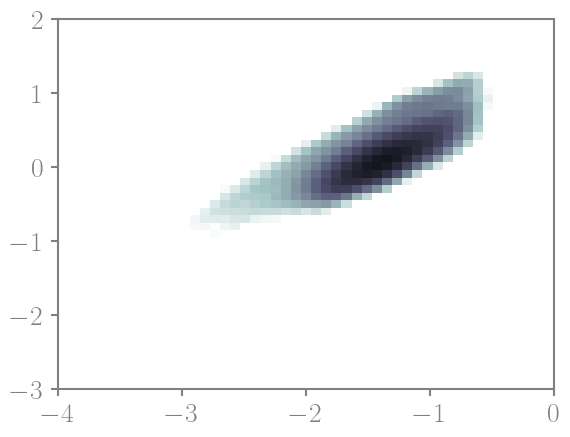

In [5]:
# scatter against each other
tau_deps, tau_dyns, SFRs = tau_deps_PRFM[0], tau_dyns_PRFM[0], SFRs_PRFM[0]
frac_SFR, _, _, _ = binned_statistic_2d(
    np.log10(tau_dyns), np.log10(tau_deps),
    SFRs, statistic='sum',
    bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
)
frac_SFR /= np.sum(frac_SFR)
plt.imshow(frac_SFR.T, origin='lower',
                 extent=(-4., 0., -3., 2.), aspect='auto',
                 cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-5, vmax=1.e-1))
plt.show()

## PRFM, resolved

In [9]:
dirs_PRFM_r = [
    '/LtU/LOW-PRFM_RSLVD/'
]
tau_deps_PRFM_r, tau_dyns_PRFM_r, SFRs_PRFM_r = [], [], []
for dir_PRFM_r in dirs_PRFM_r:
    filenames_Sfr = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_PRFM_r+'/output/Sfr_proj_*') # Msol/kpc^2/yr
    filenames_Veldisp = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_PRFM_r+'/output/Veldisp_proj_*')
    filenames_PDE = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_PRFM_r+'/output/PDE_proj_*')
    filenames_Sigmagas = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_PRFM_r+'/output/density_proj_*') # 10^9 Msol/kpc^2

    files_Sfr = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in filenames_Sfr], filenames_Sfr))]
    files_Veldisp = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in filenames_Veldisp], filenames_Veldisp))]
    files_PDE = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in filenames_PDE], filenames_PDE))]
    files_Sigmagas = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in filenames_Sigmagas], filenames_Sigmagas))]

    # load all as a flat raveled array
    Sfrs = np.array([np.ravel(get_image_data(file)) for file in files_Sfr]).flatten()
    Veldisps = np.array([np.ravel(get_image_data(file)) for file in files_Veldisp]).flatten()
    PDEs = np.array([np.ravel(get_image_data(file)) for file in files_PDE]).flatten()
    Sigmagas = np.array([np.ravel(get_image_data(file)) for file in files_Sigmagas]).flatten()

    # depletion time, something to do with how projected values are calculated?
    tau_deps = Sigmagas * 0.08**2 / Sfrs
    tau_deps_PRFM_r.append(tau_deps)
    SFRs_PRFM_r.append(Sfrs)

    # dynamical time, probably out by some kB factor in internal units
    press_unit = 1.e9*1.99e33*(1.e5)**2/(3.086e21)**3
    Sigma_unit = 1.e9*1.99e33/(3.086e21)**2
    Veldisp_unit = 1.e5
    tau_dyns = (Sigmagas*Sigma_unit * Veldisps*Veldisp_unit / (PDEs*press_unit)) / ah.Gyr_to_s
    tau_dyns_PRFM_r.append(tau_dyns)

/tmp/ipykernel_3985410/4220168022.py:23: RuntimeWarning: divide by zero encountered in divide
  tau_deps = Sigmagas * 0.08**2 / Sfrs
/tmp/ipykernel_3985410/4220168022.py:31: RuntimeWarning: invalid value encountered in divide
  tau_dyns = (Sigmagas*Sigma_unit * Veldisps*Veldisp_unit / (PDEs*press_unit)) / ah.Gyr_to_s


/tmp/ipykernel_3985410/821732071.py:4: RuntimeWarning: invalid value encountered in log10
  np.log10(tau_dyns), np.log10(tau_deps),


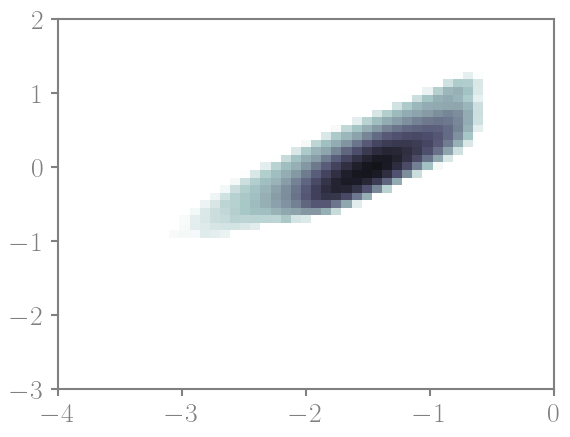

In [10]:
# scatter against each other
tau_deps, tau_dyns, SFRs = tau_deps_PRFM_r[0], tau_dyns_PRFM_r[0], SFRs_PRFM_r[0]
frac_SFR, _, _, _ = binned_statistic_2d(
    np.log10(tau_dyns), np.log10(tau_deps),
    SFRs, statistic='sum',
    bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
)
frac_SFR /= np.sum(frac_SFR)
plt.imshow(frac_SFR.T, origin='lower',
                 extent=(-4., 0., -3., 2.), aspect='auto',
                 cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-5, vmax=1.e-1))
plt.show()

## Springel & Hernquist 03

In [14]:
dirs_SH03 = [
    '/LtU/LOW-SH03/'
]
tags = ['MW']

tau_deps_SH03, tau_dyns_SH03, SFRs_SH03 = [], [], []
for tag, dir_SH03 in zip(tags, dirs_SH03):
    # depletion times
    filenames_Sfr = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_SH03+'/output/Sfr_proj_*') # Msol/kpc^2/yr
    filenames_temp = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_SH03+'/output/temp_proj_*')
    filenames_Sigmagas = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_SH03+'/output/density_proj_*') # 10^9 Msol/kpc^2

    files_Sfr = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in filenames_Sfr], filenames_Sfr))]
    files_temp = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in filenames_temp], filenames_temp))]
    files_Sigmagas = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in filenames_Sigmagas], filenames_Sigmagas))]

    # load all as a flat raveled array
    Sfrs = np.array([np.ravel(get_image_data(file)) for file in files_Sfr]).flatten()
    temps = np.array([np.ravel(get_image_data(file)) for file in files_temp]).flatten()
    Sigmagas = np.array([np.ravel(get_image_data(file)) for file in files_Sigmagas]).flatten()

    # depletion time, something to do with how projected values are calculated?
    tau_deps = Sigmagas * 0.08**2 / Sfrs
    tau_deps_SH03.append(tau_deps)
    SFRs_SH03.append(Sfrs)

    # dynamical times
    tag = 'MW'
    config = configparser.ConfigParser()
    config.read('../../GalactISM/config_prfm-check.ini')

    prfm_array = min(glob.glob(str(Path(config[tag]['ROOT_DIR']) / Path(config[tag]['SUBDIR'])) + '/prfm_*.pkl'))

    with open(prfm_array, "rb") as f:
        prfm_dict = pickle.load(f)
        star_surfdens = np.ravel(prfm_dict['star_surfdens'])
        Omega = np.ravel(prfm_dict['Omega'])

    # dynamical time, probably out by some kB factor in internal units
    Sigmagas *= 1.e9 * ah.Msol_to_g / (ah.kpc_to_cm)**2
    Utherm = (temps * ah.kB_cgs) / (ah.gamma - 1.0)
    Sigma_gs = Sigmagas + star_surfdens
    PDE = (ah.gamma - 1.0) * Utherm # initialize
    sigmaEff = 12. * ah.kms_to_cms # initialize
    i = 0
    while i < 5:
        print(np.nanmedian(PDE/ah.kB_cgs), np.nanmedian(sigmaEff/1.e5))
        PDE = Sigmagas / 4. * (np.pi * ah.G_cgs * Sigma_gs + ((np.pi * ah.G_cgs)**2 * Sigma_gs**2 + 8./3. * Omega**2 * sigmaEff**2)**0.5)
        sigmaEff = 12. * ah.kms_to_cms * (PDE / (1.e4 * ah.kB_cgs))**(0.22)
        i += 1

    tau_dyn = Sigmagas * sigmaEff / PDE / ah.Gyr_to_s
    tau_dyns_SH03.append(tau_dyn)

/tmp/ipykernel_3985410/1519261881.py:23: RuntimeWarning: divide by zero encountered in divide
  tau_deps = Sigmagas * 0.08**2 / Sfrs


265.71545 12.0


/tmp/ipykernel_3985410/1519261881.py:49: RuntimeWarning: invalid value encountered in power
  sigmaEff = 12. * ah.kms_to_cms * (PDE / (1.e4 * ah.kB_cgs))**(0.22)


2242.860593605051 8.636897602919994
1843.313325949224 8.27204830530755
1788.2617402898031 8.217052934821071
1779.3883739737873 8.208065449452404


/tmp/ipykernel_3985410/514630118.py:4: RuntimeWarning: invalid value encountered in log10
  np.log10(tau_dyns), np.log10(tau_deps),


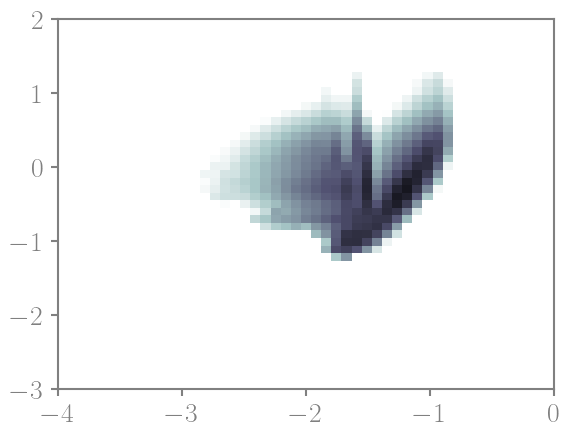

: 

In [15]:
# scatter against each other
tau_deps, tau_dyns, SFRs = tau_deps_SH03[0], tau_dyns_SH03[0], SFRs_SH03[0]
frac_SFR, _, _, _ = binned_statistic_2d(
    np.log10(tau_dyns), np.log10(tau_deps),
    SFRs, statistic='sum',
    bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
)
frac_SFR /= np.sum(frac_SFR)
plt.imshow(frac_SFR.T, origin='lower',
                 extent=(-4., 0., -3., 2.), aspect='auto',
                 cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-5, vmax=1.e-1))
plt.show()

## high-resolution galaxies

In [80]:
config = configparser.ConfigParser()
config.read('../../GalactISM/config_Forces.ini')
print(config[tag]['ROOT_DIR'])
print(config[tag]['SUBDIR'])

/n/holystore01/LABS/itc_lab/Users/sjeffreson
MW-tracers


In [81]:
allgas_arrays = glob.glob(str(Path(config[tag]['ROOT_DIR']) / Path(config[tag]['SUBDIR'])) + '/allgas_*.pkl')
allgas_nos = [arr.rsplit('_' + tag)[0].rsplit('allgas_')[1] for arr in allgas_arrays]
allgas_arrays = [arr for _, arr in sorted(zip(allgas_nos, allgas_arrays))]
print(allgas_arrays)

coolgas_arrays = glob.glob(str(Path(config[tag]['ROOT_DIR']) / Path(config[tag]['SUBDIR'])) + "/coolgas_*T2.0e+04_avir2.0e+00.pkl")
coolgas_nos = [arr.rsplit('_' + tag)[0].rsplit('coolgas_')[1] for arr in coolgas_arrays]
coolgas_arrays = [arr for _, arr in sorted(zip(coolgas_nos, coolgas_arrays))]
print(coolgas_arrays)

['/n/holystore01/LABS/itc_lab/Users/sjeffreson/MW-tracers/allgas_600_MW.pkl']
['/n/holystore01/LABS/itc_lab/Users/sjeffreson/MW-tracers/coolgas_600_MW_T2.0e+04_avir2.0e+00.pkl']


In [82]:
tau_deps_hr, tau_dyns_hr, Sigma_SFRs_hr = [], [], []
for allgas_array, coolgas_array in zip(allgas_arrays, coolgas_arrays):
    with open(allgas_array, "rb") as f:
        allgas_dict = pickle.load(f)
    with open(coolgas_array, "rb") as f:
        coolgas_dict = pickle.load(f)

    # depletion times
    tau_dep = allgas_dict['gas_surfdens'] / allgas_dict['SFR_surfdens']
    Sigma_SFR = allgas_dict['SFR_surfdens']
    cnd = (tau_dep > 0) & ~np.isinf(tau_dep)
    tau_deps_hr.extend(tau_dep[cnd])
    Sigma_SFRs_hr.extend(Sigma_SFR[cnd])

    # dynamical times
    tau_dyn = coolgas_dict['gas_surfdens'] * coolgas_dict['veldisp_midplane'] / (coolgas_dict['Pturb'] + coolgas_dict['Ptherm'])
    tau_dyns_hr.extend(tau_dyn[cnd])
tau_deps_hr = np.array(tau_deps_hr)
tau_dyns_hr = np.array(tau_dyns_hr)
Sigma_SFRs_hr = np.array(Sigma_SFRs_hr)

/tmp/ipykernel_3861746/2339690200.py:9: RuntimeWarning: divide by zero encountered in divide
  tau_dep = allgas_dict['gas_surfdens'] / allgas_dict['SFR_surfdens']
/tmp/ipykernel_3861746/2339690200.py:9: RuntimeWarning: invalid value encountered in divide
  tau_dep = allgas_dict['gas_surfdens'] / allgas_dict['SFR_surfdens']


# figure

/tmp/ipykernel_3861746/698090257.py:13: RuntimeWarning: invalid value encountered in log10
  np.log10(tau_dyns), np.log10(tau_deps),
/tmp/ipykernel_3861746/698090257.py:27: RuntimeWarning: invalid value encountered in log10
  np.log10(tau_dyns), np.log10(tau_deps),
/tmp/ipykernel_3861746/698090257.py:40: RuntimeWarning: invalid value encountered in log10
  np.log10(tau_dyns/ah.Gyr_to_s), np.log10(tau_deps),


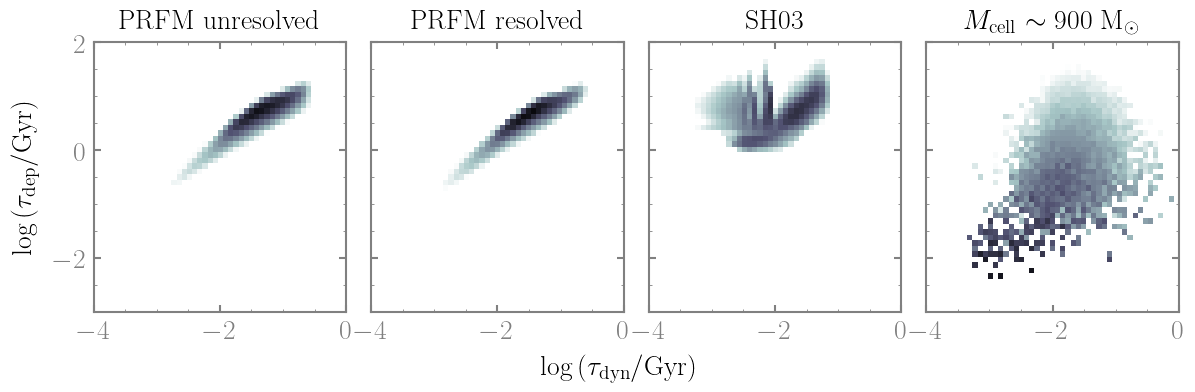

In [83]:
# 2D histogram of tau_dyn (x-axis) vs. tau_dep (y-axis) for PRFM and control (SH03) case,
# on two separate axes
fig, ax = plt.subplots(1, 4, figsize=(14, 3.5))

for ax_ in ax:
    ax_.tick_params(axis = 'both', bottom = True, top = True, left = True, right = True,
                   which = 'both', direction='in')
    ax_.minorticks_on()

# PRFM unresolved
tau_deps, tau_dyns, SFRs = tau_deps_PRFM[0], tau_dyns_PRFM[0], SFRs_PRFM[0]
frac_SFR, _, _, _ = binned_statistic_2d(
    np.log10(tau_dyns), np.log10(tau_deps),
    SFRs, statistic='sum',
    bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
)
frac_SFR /= np.sum(frac_SFR)
frac_SFR /= np.sum(frac_SFR)
ax[0].imshow(frac_SFR.T, origin='lower',
                 extent=(-4., 0., -3., 2.), aspect='auto',
                 cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-4, vmax=1.e-1))
ax[0].set_title('PRFM unresolved', pad=10, fontsize=20)

# PRFM resolved
tau_deps, tau_dyns, SFRs = tau_deps_PRFM_r[0], tau_dyns_PRFM_r[0], SFRs_PRFM_r[0]
frac_SFR, _, _, _ = binned_statistic_2d(
    np.log10(tau_dyns), np.log10(tau_deps),
    SFRs, statistic='sum',
    bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
)
frac_SFR /= np.sum(frac_SFR)
ax[1].imshow(frac_SFR.T, origin='lower',
                 extent=(-4., 0., -3., 2.), aspect='auto',
                 cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-4, vmax=1.e-1))
ax[1].set_title('PRFM resolved', pad=10, fontsize=20)

# SH03
tau_deps, tau_dyns, SFRs = tau_deps_SH03[0], tau_dyns_SH03[0], SFRs_SH03[0]
frac_SFR, _, _, _ = binned_statistic_2d(
    np.log10(tau_dyns/ah.Gyr_to_s), np.log10(tau_deps),
    SFRs, statistic='sum',
    bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
)
frac_SFR /= np.sum(frac_SFR)
ax[2].imshow(frac_SFR.T, origin='lower',
                 extent=(-4., 0., -3., 2.), aspect='auto',
                 cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-4, vmax=1.e-1))
ax[2].set_title('SH03', pad=10, fontsize=20)

# high-resolution
frac_SFR, _, _, _ = binned_statistic_2d(
    np.log10(tau_dyns_hr/ah.kB_cgs/ah.Gyr_to_s), np.log10(tau_deps_hr/ah.Gyr_to_s),
    Sigma_SFRs_hr, statistic='sum',
    bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
)
frac_SFR /= np.sum(frac_SFR)
ax[3].imshow(frac_SFR.T, origin='lower',
             extent=(-4., 0., -3., 2.), aspect='auto',
             cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-5, vmax=1.e-1))
ax[3].set_title(r'$M_{\rm cell} \sim 900~{\rm M}_\odot$', pad=10, fontsize=20)

# remove y-labels
for i in range(1, 4):
    ax[i].set_yticklabels([])

ax[0].set_ylabel(r'$\log{(\tau_{\rm dep}/{\rm Gyr})}$', color='k')
fig.text(0.5, -0.05, r'$\log{(\tau_{\rm dyn}/{\rm Gyr})}$', ha='center', va='center')

plt.subplots_adjust(hspace=0.1, wspace=0.1)

# plt.savefig(
#     '/n/holystore01/LABS/itc_lab/Users/sjeffreson/PRFM-unresolved/figs/ETG-vlM_prelim.pdf',
#     bbox_inches='tight',
#     format='pdf'
# )
plt.show()